<a href="https://colab.research.google.com/github/TGAmbra/GSOC-2023/blob/main/GSOC_MultiG_Keras_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Learning to Generate 3D Shapes from a Single Example**

In [2]:
!pip install pyglet
!pip install PyMCubes
!pip install trimesh
!pip install protobuf
!apt-get -y install protobuf-compiler python-pil python-lxml
!pip install --upgrade protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.7/854.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.0/687.0 kB 11.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-pil
E: Unable to locate package python-lxml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.


In [3]:
import h5py
import numpy
import PIL
import os
import pyglet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.math import reduce_mean
from tensorflow.python.ops.gen_nn_ops import leaky_relu
from mcubes import marching_cubes
import skimage
import scipy
import tqdm
import trimesh

import google.protobuf
print(h5py.__version__, numpy.__version__, PIL.__version__,
      skimage.__version__, scipy.__version__, tqdm.__version__, trimesh.__version__,
      google.protobuf.__version__)

#check if you need to update numpy, PIL, scipy

3.9.0 1.23.5 9.4.0 0.19.3 1.11.3 4.66.1 4.0.0 3.20.3


h5py==3.6.0
numpy==1.22.3
Pillow==9.0.1
pyglet==1.5.26
PyMCubes==0.1.2
scikit-image==0.19.2
scipy==1.7.3
torch>=1.11.0
tqdm==4.64.0
trimesh==3.12.5
open3d==0.15.2
tensorboardX==2.5 use keras function
protobuf==3.20.2

In [4]:
## Visualise model and load file from url
#Loading file from url
path_to_downloaded_file = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/data/elm_small_spring.obj",
)
path = os.path.join(os.path.dirname(path_to_downloaded_file), 'elm_small_spring.obj')
print(path)
mesh = trimesh.load(path)
mesh.show()

164686/164686 [==============================] - 0s 2us/step
/root/.keras/datasets/elm_small_spring.obj


# Creating 9 Input Scales for Elm Tree Model
In line with the data configuration specified in Table 5 "Data Configuration", the Elm Tree model undergoes training across 9 scales. For each scale, we voxelize the input data 9 times, starting with a voxel size of 0.025 and subsequently applying a downsampling ratio of r, with  $r = 0.75$.

**Problem**

However, it was observed that in Generator N, instead of the expected $r = 0.75$, it upsampled with $r = 0.5$. This is evident in the voxel dimensions after Generator N:

```python
Shapes of Gen2:  (1, 32, 44, 64) (1, 32, 44, 40) (1, 32, 64, 40) #(44, 64, 40)
Shapes of Gen3:  (1, 32, 88, 128) (1, 32, 88, 80) (1, 32, 128, 80) # (88,128, 80)
Shapes of Gen4:  (1, 32, 176, 256) (1, 32, 176, 160) (1, 32, 256, 160) #(176,256,160)
Shapes of Gen5:  (1, 32, 352, 512) (1, 32, 352, 320) (1, 32, 512, 320) #(352,512,320)
```
According to the paper's instructions,
*If the smallest dimension of any 𝑥𝑖 is less than 15 voxels, we resize that dimension to be 15.*
To address both of these issues, we reset r to 0.25 and initiate the process with a voxel size of 0.22, resulting in $shape = (16, 23, 15)$. We can only achieve 3 training scales resulting in $shape = (128, 184, 120)$.

In [5]:
#Voxelise and normalise
import numpy as np
# normalise within unit sphere:
def normalize_unit_sphere(vertices):
  mean_vertices = np.mean(vertices, axis=0)
  vertices -= mean_vertices # mean subtracted from all vertices
  max_distance = np.max(np.sqrt(np.sum(abs(vertices)**2,axis=-1))) #max distance from origin
  vertices /= max_distance #all vertices are divided by the maximum of such distances
  #All distances are scaled to the range -1.0 and 1.0.
  return vertices

# ## Maximum scale 3
# # binary mask and padding to create filling
# #pads 0 around occupied voxels

## Scale 3
# 0.055*0.5 = 0.0275 (128, 184,120)
original_voxels_3 = np.pad(mesh.voxelized(0.024).matrix.astype(int),((5,5),(0,0),(5,6))) #0.001 crashed my ram
print("original_voxels_3:", original_voxels_3.shape)

## Scale 2
# 0.11*0.5 = 0.055 (64, 92, 60)
original_voxels_2 = np.pad(mesh.voxelized(0.0485).matrix.astype(int),((2,3),(0,0),(3,3))) #0.001 crashed my ram
print("original_voxels_2:", original_voxels_2.shape)

## Scale 1
# 0.22*0.5 = 0.11
original_voxels_1 = mesh.voxelized(0.097).matrix.astype(int) #0.001 crashed my ram
original_voxels_1 = np.pad(original_voxels_1,((1,1),(0,0),(1,1)))
print("original_voxels_1:", original_voxels_1.shape)

## Scale 0
# 0.22
original_voxels_0 = mesh.voxelized(0.22).matrix.astype(int) #0.001 crashed my ram
original_voxels_0 = np.pad(original_voxels_0,1)
print("original_voxels_0:", original_voxels_0.shape)

vertices, faces = marching_cubes(original_voxels_0, 0.5)
volume_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
print(volume_mesh)
volume_mesh.show()

original_voxels_3: (128, 184, 120)
original_voxels_2: (64, 92, 60)
original_voxels_1: (32, 46, 30)
original_voxels_0: (16, 23, 15)
<trimesh.Trimesh(vertices.shape=(1024, 3), faces.shape=(1992, 3))>


In [6]:
#3D output = output channels, height/width/depth (2 of them)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def make_projection_model(out_channels, input_shape):
  # Create input layer
  input_data = tf.keras.Input(shape=(out_channels,*input_shape))
  # Apply AveragePooling3D with adjusted pool dimensions
  fmap = tf.keras.layers.AveragePooling3D(pool_size=(1,1,1),data_format='channels_first')
  yz_fmap = tf.reduce_mean(fmap(input_data), 4)# across W
  xz_fmap = tf.reduce_mean(fmap(input_data), 3)# across H
  xy_fmap = tf.reduce_mean(fmap(input_data), 2)#across D
  # No need to re-order dimensions DxHxW with tf.mean
  #tf.print(yz_fmap.shape, xz_fmap.shape, xy_fmap.shape)
  #Apply convolutions
  convolution = layers.Conv2D(out_channels, (1, 1), strides=(1, 1),data_format='channels_first')
  yz_fmap = convolution(yz_fmap)
  xz_fmap = convolution(xz_fmap)
  xy_fmap = convolution(xy_fmap)
  #tf.print(yz_fmap.shape, xz_fmap.shape, xy_fmap.shape)
  model = keras.Model(inputs=input_data, outputs=[yz_fmap, xz_fmap, xy_fmap], name="projection_model")
  #model.summary()
  return model

#pool_dims = 8
out_channels = 32
input_shape = original_voxels_0.shape
projection_model = make_projection_model(out_channels, input_shape)
projection_model.summary()

# #Run only if enough GPU RAM
noise = tf.random.normal((1,*original_voxels_0.shape))
noise = tf.tile(tf.expand_dims(noise, 1), [1, out_channels, 1, 1, 1])
print(noise.shape)
yz_fmap, xz_fmap, xy_fmap = projection_model(noise)
print(yz_fmap.shape, xz_fmap.shape, xy_fmap.shape)

Num GPUs Available:  1
Model: "projection_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 16, 23, 15)]     0         []                            
                                                                                                  
 average_pooling3d (Average  (None, 32, 16, 23, 15)       0         ['input_1[0][0]',             
 Pooling3D)                                                          'input_1[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 32, 16, 23)           0         ['average_pooling3d[0][0]']   
 ambda)                                                     

In [7]:
# make G0 model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def make_generator0_model(output_channels,input_shape_yz,input_shape_xz, input_shape_xy):
  #Define inputs
  yz_fmap = tf.keras.Input(shape=(output_channels,*input_shape_yz))
  xz_fmap = tf.keras.Input(shape=(output_channels,*input_shape_xz))
  xy_fmap = tf.keras.Input(shape=(output_channels,*input_shape_xy))
  #Convolution block
  conv_layer = tf.keras.layers.Conv2D(output_channels, (3,3), strides=(1, 1),data_format="channels_first", padding = "same") #passing same to get 256 instead of 254
  in_layer = tf.keras.layers.BatchNormalization(axis=-1) # axis=-1 last dimension has to match, to re use the layer
  # create new instance normalisation layer as yz_fmap has different last dimension
  in__layer = tf.keras.layers.BatchNormalization(axis=-1)
  lrelu_layer = layers.LeakyReLU(alpha = 0.2) #negative slope=0.2
  #Apply the convolution block to each feature_map
  xy_tmap = lrelu_layer(in_layer(conv_layer(xy_fmap)))
  xz_tmap = lrelu_layer(in_layer(conv_layer(xz_fmap)))
  yz_tmap = lrelu_layer(in__layer(conv_layer(yz_fmap)))
  #tf.print(yz_tmap.shape, xz_tmap.shape, xy_tmap.shape)
  model = keras.Model(inputs=[yz_fmap, xz_fmap, xy_fmap], outputs=[yz_tmap, xz_tmap, xy_tmap], name="generator0_model")
  return model

output_channels = 32

##Uncomment if you have 40+ GPU RAM
input_shape_yz = yz_fmap.numpy().shape[-2:]
input_shape_xz= xz_fmap.numpy().shape[-2:]
input_shape_xy= xy_fmap.numpy().shape[-2:]

# input_shape_yz = (11, 16)
# input_shape_xz= (11, 10)
# input_shape_xy= (16, 10)
#print(input_shape_yz,input_shape_xz, input_shape_xy)
generator0_model = make_generator0_model(output_channels, input_shape_yz,input_shape_xz, input_shape_xy)
generator0_model.summary()
#Uncomment if you have 40+ GPU RAM
yz_tmap, xz_tmap, xy_tmap = generator0_model([yz_fmap, xz_fmap, xy_fmap]) #no last convolution
print(yz_tmap.shape, xz_tmap.shape, xy_tmap.shape)


Model: "generator0_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 16, 23)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 32, 16, 15)]         0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 32, 23, 15)]         0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           multiple                     9248      ['input_4[0][0]',             
                                                                     'input_3[0][0]

In [8]:
# make GN model
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#grows in size
def make_generatorN_model(output_channels,input_shape_yz, input_shape_xz, input_shape_xy, training = "False"):
  #Define inputs
  yz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_yz))
  xz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xz))
  xy_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xy))

  #Bilinear upsample to add details
  #randomly chosen size
  upsample_layer = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = "bilinear",data_format="channels_first")
  yz_tmap_out = upsample_layer(yz_tmap) #shape = (None, 32, 508, 508)
  xz_tmap_out = upsample_layer(xz_tmap)
  xy_tmap_out = upsample_layer(xy_tmap)

  #Add noise
  if training == True:
    yz_tmap_noise = tf.random.normal((1,*yz_tmap_out.shape[1:]),
                                             mean = tf.math.reduce_mean(yz_tmap_out),
                                             stddev = tf.math.reduce_std(yz_tmap_out))
    xz_tmap_noise = tf.random.normal((1,*xz_tmap_out.shape[1:]),
                                             mean = tf.math.reduce_mean(xz_tmap_out),
                                             stddev = tf.math.reduce_std(xz_tmap_out))
    xy_tmap_noise = tf.random.normal((1,*xy_tmap_out.shape[1:]),
                                             mean = tf.math.reduce_mean(xy_tmap_out),
                                             stddev = tf.math.reduce_std(xy_tmap_out))
  else:
    yz_tmap_noise = 0
    xz_tmap_noise = 0
    xy_tmap_noise = 0

  yz_tmap_out = yz_tmap_out+yz_tmap_noise
  xz_tmap_out = xz_tmap_out+xz_tmap_noise
  xy_tmap_out = xy_tmap_out+xy_tmap_noise
  # tf.print(xz_tmap_out.shape, xy_tmap_out.shape,yz_tmap_out.shape)
  # tf.print(xz_tmap.shape, xy_tmap.shape,yz_tmap.shape)

  #Convolution block
  conv_layer = layers.Conv2D(32, (3,3), strides=(1, 1),data_format="channels_first", padding="same")
  in_layer = layers.BatchNormalization(axis=-1)
  in__layer = layers.BatchNormalization(axis=-1)
  lrelu_layer = layers.LeakyReLU(alpha = 0.2) #negative slope=0.2

  #Apply the convolution block to each feature_map
  xz_tmap_out = lrelu_layer(in_layer(conv_layer(xz_tmap_out)))
  xy_tmap_out = lrelu_layer(in_layer(conv_layer(xy_tmap_out)))
  yz_tmap_out = lrelu_layer(in__layer(conv_layer(yz_tmap_out)))

  #Residual/Skip-add connections
  #Use zero-padding and conv2D to make input shapes match
  #Create custom padding layer as all shapes are different
  #((top_pad, bottom_pad), (left_pad, right_pad))
  zero_pad_layer_yz = layers.ZeroPadding2D(padding=tuple((math.floor(ti/2), math.ceil(ti/2)) for ti in yz_tmap.shape[-2:]), data_format="channels_first")
  zero_pad_layer_xz = layers.ZeroPadding2D(padding=tuple((math.floor(ti/2), math.ceil(ti/2)) for ti in xz_tmap.shape[-2:]), data_format="channels_first")
  zero_pad_layer_xy = layers.ZeroPadding2D(padding=tuple((math.floor(ti/2), math.ceil(ti/2)) for ti in xy_tmap.shape[-2:]), data_format="channels_first")

  #print(zero_pad_layer_yz(conv_layer(yz_tmap)).shape, yz_tmap_out.shape)
  yz_tmap_out = layers.Add()([yz_tmap_out, zero_pad_layer_yz(conv_layer(yz_tmap))])
  xz_tmap_out = layers.Add()([xz_tmap_out, zero_pad_layer_xz(conv_layer(xz_tmap))])
  xy_tmap_out = layers.Add()([xy_tmap_out, zero_pad_layer_xy(conv_layer(xy_tmap))])
  #tf.print(yz_tmap_out.shape, xz_tmap_out.shape, xy_tmap_out.shape)
  model = keras.Model(inputs=[yz_tmap, xz_tmap, xy_tmap], outputs=[yz_tmap_out, xz_tmap_out, xy_tmap_out], name="generatorN_model")
  return model

output_channels = 32
##Uncomment if you have 40+ GPU RAM
input_shape_yz = yz_tmap.numpy().shape[-2:]
input_shape_xz= xz_tmap.numpy().shape[-2:]
input_shape_xy= xy_tmap.numpy().shape[-2:]

print(input_shape_yz, input_shape_xz, input_shape_xy)
generator1_model = make_generatorN_model(output_channels, input_shape_yz, input_shape_xz, input_shape_xy)
generator1_model.summary()

#Uncomment if you have 40+ GPU RAM
yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1 = generator1_model([yz_tmap, xz_tmap, xy_tmap]) #no last convolution
print(yz_tmap_out_1.shape, xz_tmap_out_1.shape, xy_tmap_out_1.shape)

(16, 23) (16, 15) (23, 15)
Model: "generatorN_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 16, 23)]         0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 32, 16, 15)]         0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 32, 23, 15)]         0         []                            
                                                                                                  
 up_sampling2d (UpSampling2  multiple                     0         ['input_5[0][0]',             
 D)                                                     

In [9]:
#Generator 2
generator2_model = make_generatorN_model(output_channels, yz_tmap_out_1.numpy().shape[-2:], xz_tmap_out_1.numpy().shape[-2:], xy_tmap_out_1.numpy().shape[-2:])
yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2 = generator2_model([yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1]) #no last convolution
print("Generator 2:", yz_tmap_out_2.shape, xz_tmap_out_2.shape, xy_tmap_out_2.shape)

#Generator 3
generator3_model = make_generatorN_model(output_channels, yz_tmap_out_2.numpy().shape[-2:], xz_tmap_out_2.numpy().shape[-2:], xy_tmap_out_2.numpy().shape[-2:])
yz_tmap_out_3, xz_tmap_out_3, xy_tmap_out_3 = generator3_model([yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2]) #no last convolution
print("Generator 3:", yz_tmap_out_3.shape, xz_tmap_out_3.shape, xy_tmap_out_3.shape)

Generator 2: (1, 32, 64, 92) (1, 32, 64, 60) (1, 32, 92, 60)
Generator 3: (1, 32, 128, 184) (1, 32, 128, 120) (1, 32, 184, 120)


In [10]:
## Grid sampling functions
import tensorflow as tf
#@tf.function
def make_coords(H, W, D, normalize=True):
        # Create coordinate grids using meshgrid
        #normalise values between -1 and 1
    xs, ys, zs = tf.meshgrid(
        tf.linspace(-1.0, 1.0, H) if normalize else tf.range(H, dtype=tf.float32),
        tf.linspace(-1.0, 1.0, W) if normalize else tf.range(W, dtype=tf.float32),
        tf.linspace(-1.0, 1.0, D) if normalize else tf.range(D, dtype=tf.float32),
        indexing='ij'
    )

    # Stack the coordinate grids to create the final coordinates tensor
    coords = tf.stack([xs, ys, zs], axis=-1)
    #print(coords.shape)

    return coords

# Perform bilinear interpolation for each feature map
#weighted sum of the values of the four nearest grid points in the feature map based on the interpolation weights
#@tf.function
def bilinear_interpolation(feat_map, x, y, z, coord_x, coord_y,coord_z):
  # Prepare indices for interpolation
    x0 = coord_x
    x1 = x0 + 1
    y0 = coord_y
    y1 = y0 + 1
    z0 = coord_z
    z1 = z0 + 1

    # Ensure indices are within valid range
    # avoid out-of-bounds access (0 to H-1, 0 to W-1, 0 to D-1)
    x0 = tf.clip_by_value(x0, 0, input_shape[0] - 1)
    x1 = tf.clip_by_value(x1, 0, input_shape[0] - 1)
    y0 = tf.clip_by_value(y0, 0, input_shape[1] - 1)
    y1 = tf.clip_by_value(y1, 0, input_shape[1] - 1)
    z0 = tf.clip_by_value(z0, 0, input_shape[2] - 1)
    z1 = tf.clip_by_value(z1, 0, input_shape[2] - 1)

    # weights
    w000 = (1 - x) * (1 - y) * (1 - z)
    w100 = x * (1 - y) * (1 - z)
    w010 = (1 - x) * y * (1 - z)
    w110 = x * y * (1 - z)
    w001 = (1 - x) * (1 - y) * z
    w101 = x * (1 - y) * z
    w011 = (1 - x) * y * z
    w111 = x * y * z

#stack weights together
    indices_000 = tf.stack([x0, y0, z0], axis=1)
    indices_100 = tf.stack([x1, y0, z0], axis=1)
    indices_010 = tf.stack([x0, y1, z0], axis=1)
    indices_110 = tf.stack([x1, y1, z0], axis=1)
    indices_001 = tf.stack([x0, y0, z1], axis=1)
    indices_101 = tf.stack([x1, y0, z1], axis=1)
    indices_011 = tf.stack([x0, y1, z1], axis=1)
    indices_111 = tf.stack([x1, y1, z1], axis=1)

#Get values of 8 surrounding data points
    value_000 = tf.gather_nd(feat_map, indices_000)
    value_100 = tf.gather_nd(feat_map, indices_100)
    value_010 = tf.gather_nd(feat_map, indices_010)
    value_110 = tf.gather_nd(feat_map, indices_110)
    value_001 = tf.gather_nd(feat_map, indices_001)
    value_101 = tf.gather_nd(feat_map, indices_101)
    value_011 = tf.gather_nd(feat_map, indices_011)
    value_111 = tf.gather_nd(feat_map, indices_111)

    #print(w000[..., tf.newaxis].shape, value_000.shape)
    #GN: (17456080, 1) (17456080, 32)

    interpolated_value = (
        w000[..., tf.newaxis] * value_000 +
        w100[..., tf.newaxis] * value_100 +
        w010[..., tf.newaxis] * value_010 +
        w110[..., tf.newaxis] * value_110 +
        w001[..., tf.newaxis] * value_001 +
        w101[..., tf.newaxis] * value_101 +
        w011[..., tf.newaxis] * value_011 +
        w111[..., tf.newaxis] * value_111
    )

    return interpolated_value


#(2182010, 32) (2182010, 32) (2182010, 32)
#yz_tmap_out, xz_tmap_out, xy_tmap_out

In [11]:
# make MLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# MLP Architecture
def make_MLP_model(input_shape_yz,input_shape_xz, input_shape_xy, output_channels,training):
    #Define inputs
    yz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_yz))
    xz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xz))
    xy_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xy))
    #print(input_shape_yz[0],input_shape_yz[1], input_shape_xz[1])
    #Define layers
    permute_layer = layers.Permute((2,3,1)) #dense inputs channels last
    relu_layer = layers.Dense(32, activation='relu')
    sigmoid_layer = layers.Dense(1, activation='sigmoid')
    #Define output features
    yz_map = relu_layer(permute_layer(yz_tmap))
    xz_map = relu_layer(permute_layer(xz_tmap))
    xy_map = relu_layer(permute_layer(xy_tmap))
    #print(yz_map.shape, xz_map.shape, xy_map.shape)

    # Define grid dimensions
    # Each row = 3D coord point in the grid , Assuming coords has shape (115, 179, 106, 3)
    coord = make_coords(input_shape_yz[0],input_shape_yz[1], input_shape_xz[1])
    #print(coord.shape)
    coords_reshaped = tf.reshape(coord, [-1, 3])  # Reshape coords to (H*W*D, 3)
    #print(coords_reshaped.shape)
    # Extract individual components of coordinates
    #Floor coordinates to integers for indexing
    # rounds each coord of grid to nearest int and double check that only int32 values are there
    coord_x = tf.cast(tf.math.floor(coords_reshaped[:, 0]), dtype=tf.int32)
    coord_y = tf.cast(tf.math.floor(coords_reshaped[:, 1]), dtype=tf.int32)
    coord_z = tf.cast(tf.math.floor(coords_reshaped[:, 2]), dtype=tf.int32)

    # Calculate the weights for interpolation
    #Get fractional part of each coord
    x_weight = coords_reshaped[:, 0] - tf.cast(coord_x, dtype=tf.float32)# point x coord-float grid
    y_weight = coords_reshaped[:, 1] - tf.cast(coord_y, dtype=tf.float32)
    z_weight = coords_reshaped[:, 2] - tf.cast(coord_z, dtype=tf.float32)

    #GO: (2182010, 32) (2182010, 32) (2182010, 32)
    #GN: (17456080, 32)
    sample_yz_feat = bilinear_interpolation(yz_map, x_weight, y_weight, z_weight,coord_x, coord_y,coord_z)
    sample_xz_feat = bilinear_interpolation(xz_map, x_weight, y_weight, z_weight,coord_x, coord_y,coord_z)
    sample_xy_feat = bilinear_interpolation(xy_map, x_weight, y_weight, z_weight,coord_x, coord_y,coord_z)
    print("finished bilinear interpo")
    # Reshape the sampled features to match your desired shape
    sample_yz_feat = tf.reshape(sample_yz_feat, [input_shape_yz[0], input_shape_yz[1], input_shape_xz[1], 32])
    sample_xz_feat = tf.reshape(sample_xz_feat, [input_shape_yz[0], input_shape_yz[1], input_shape_xz[1], 32])
    sample_xy_feat = tf.reshape(sample_xy_feat, [input_shape_yz[0], input_shape_yz[1], input_shape_xz[1], 32])
    #print(sample_xy_feat.shape, sample_xz_feat.shape,  sample_yz_feat.shape)
    #Define occupancy probability volume
    o_p = sigmoid_layer(tf.keras.layers.Concatenate(axis=-1)([sample_xy_feat, sample_xz_feat,  sample_yz_feat]))
    #tf.print("finished op", o_p.shape)
    model = keras.Model(inputs=[yz_tmap, xz_tmap, xy_tmap], outputs=o_p, name="MLP_train_model")
    return model

#Occupancy probability: the probability of 𝑝 being occupied by the 3D shape.
output_channels = 32
##Uncomment if you have 40+ GPU RAM

training = True
#training = False
mlp_0 = make_MLP_model(yz_tmap.numpy().shape[-2:], xz_tmap.numpy().shape[-2:], xy_tmap.numpy().shape[-2:],output_channels, training)
mlp_0.summary()
mlp_1 = make_MLP_model(yz_tmap_out_1.numpy().shape[-2:], xz_tmap_out_1.numpy().shape[-2:], xy_tmap_out_1.numpy().shape[-2:],output_channels, training)
#mlp_1.summary()
mlp_2 = make_MLP_model(yz_tmap_out_2.numpy().shape[-2:], xz_tmap_out_2.numpy().shape[-2:], xy_tmap_out_2.numpy().shape[-2:],output_channels, training)
mlp_3 = make_MLP_model(yz_tmap_out_3.numpy().shape[-2:], xz_tmap_out_3.numpy().shape[-2:], xy_tmap_out_3.numpy().shape[-2:],output_channels, training)

##Uncomment if you have 40+ GPU RAM
o_p_0= mlp_0([yz_tmap, xz_tmap, xy_tmap])
print(o_p_0.shape)
o_p_1= mlp_1([yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1])
print(o_p_1.shape)
o_p_2= mlp_2([yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2])
print(o_p_2.shape)
o_p_3= mlp_3([yz_tmap_out_3, xz_tmap_out_3, xy_tmap_out_3])
print(o_p_3.shape)

finished bilinear interpo
Model: "MLP_train_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 32, 23, 15)]         0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 32, 16, 15)]         0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 32, 16, 23)]         0         []                            
                                                                                                  
 permute (Permute)           multiple                     0         ['input_14[0][0]',            
                                                          

In [12]:
from tensorflow.python.ops.gen_nn_ops import leaky_relu
from tensorflow import keras
def make_discriminator_model(input_shape,output_channels):
  #Define inputs output_channels
  #print(input_shape)
  voxels = tf.keras.Input(shape=(output_channels,*input_shape))#input of conv3d must be channels last
  #print(voxels.shape)
  #Define layer
  convo_layer = tf.keras.layers.Conv3D(output_channels,(3,3,3), strides=(2,2,2), padding='same',data_format="channels_first")
  last_convo = tf.keras.layers.Conv3D(1,(3,3,3), strides=(2,2,2), padding='same',data_format="channels_first")
  batch_norm = tf.keras.layers.BatchNormalization(axis=1)
  leaky_layer = tf.keras.layers.LeakyReLU()
  #Concatenate all together
  output_first_convo_block = leaky_layer(batch_norm(convo_layer(voxels)))
  output_sec_convo_block = leaky_layer(batch_norm(convo_layer(output_first_convo_block)))
  score_map = last_convo(output_sec_convo_block)
  #Exclude the channels dimension
  #tf.print(score_map.shape)
  model = keras.Model(inputs=[voxels], outputs=score_map, name="discriminator_model")
  return model

output_channels = 32
#Training scale = 0
#score map for generated voxels gen0
reconstructed_0 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_0), 0), 0), [1,output_channels,  1, 1, 1])
discriminator_0 = make_discriminator_model(reconstructed_0.numpy().shape[-3:], output_channels)
discriminator_0.summary()
gen0_score_map = discriminator_0([reconstructed_0]) #generator 0 score map
#make score map for original 0
original_0 = tf.tile(tf.expand_dims(tf.expand_dims(original_voxels_0, 0), 0), [1,output_channels, 1, 1, 1])
score_map_0 = discriminator_0([original_0])#original input score map
print(gen0_score_map.shape, score_map_0.shape)

Model: "discriminator_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 32, 16, 23, 15)]     0         []                            
                                                                                                  
 conv3d (Conv3D)             multiple                     27680     ['input_26[0][0]',            
                                                                     'leaky_re_lu_4[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  multiple                     128       ['conv3d[0][0]',              
 chNormalization)                                                    'conv3d[1][0]']              
                                                                                

In [13]:
#Training scale = 1
#score map for generated voxels gen2
reconstructed_1 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_1), 0), 0), [1,output_channels,  1, 1, 1])
discriminator_1 = make_discriminator_model(reconstructed_1.numpy().shape[-3:], output_channels)
gen1_score_map = discriminator_1([reconstructed_1]) #generator 0 score map
#make score map for original 0
original_1 = tf.tile(tf.expand_dims(tf.expand_dims(original_voxels_1, 0), 0), [1,output_channels, 1, 1, 1])
score_map_1 = discriminator_1([original_1])#original input score map
print(gen1_score_map.shape, score_map_1.shape)

#Training scale = 2
#score map for generated voxels gen0
reconstructed_2 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_2), 0), 0), [1,output_channels,  1, 1, 1])
discriminator_2 = make_discriminator_model(reconstructed_2.numpy().shape[-3:], output_channels)
gen2_score_map = discriminator_2([reconstructed_2]) #generator 0 score map
#make score map for original 2
original_2 = tf.tile(tf.expand_dims(tf.expand_dims(original_voxels_2, 0), 0), [1,output_channels, 1, 1, 1])
score_map_2 = discriminator_2([original_2])#original input score map
print(gen2_score_map.shape, score_map_2.shape)

#Training scale = 3
#score map for generated voxels gen0
reconstructed_3 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_3), 0), 0), [1,output_channels,  1, 1, 1])
discriminator_3 = make_discriminator_model(reconstructed_3.numpy().shape[-3:], output_channels)
gen3_score_map = discriminator_3([reconstructed_3]) #generator 0 score map
#make score map for original 0
original_3 = tf.tile(tf.expand_dims(tf.expand_dims(original_voxels_3, 0), 0), [1,output_channels, 1, 1, 1])
score_map_3 = discriminator_3([original_3])#original input score map
print(gen3_score_map.shape, score_map_3.shape)

(1, 1, 4, 6, 4) (1, 1, 4, 6, 4)
(1, 1, 8, 12, 8) (1, 1, 8, 12, 8)
(1, 1, 16, 23, 15) (1, 1, 16, 23, 15)


In [20]:
# @title Generator till N=3

#paper uses WGAP_GP method
class WGAN(keras.Model):
    def __init__(
        self,
        projection_model,
        generator_list,
        mlp_list,
        discriminator_list,
        original_input_shape, #  (115, 179, 106)
        gradient_penalty_weight = 0.1,
        out_channels = 32,
    ):
        super().__init__()
        self.projection_model = projection_model
        self.generator0 = generator_list[0]
        self.generator1 = generator_list[1]
        self.generator2 = generator_list[2]
        self.generator3 = generator_list[3]

        self.mlp_0 = mlp_list[0]
        self.mlp_1 = mlp_list[1]
        self.mlp_2 = mlp_list[2]
        self.mlp_3 = mlp_list[3]

        self.discriminator_0 = discriminator_list[0]
        self.discriminator_1 = discriminator_list[1]
        self.discriminator_2 = discriminator_list[2]
        self.discriminator_3 = discriminator_list[3]

        self.original_input_shape = original_input_shape # (115, 179, 106)
        self.gradient_penalty_weight = gradient_penalty_weight
        self.out_channels = out_channels

    def compile(self, discriminator_optimizer, generator_optimizer, recontruction_loss_fn, adversarial_loss_fn):
        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.recontruction_loss_fn = recontruction_loss_fn #discriminator losss
        self.adversarial_loss_fn = adversarial_loss_fn #generator loss

    def gradient_penalty(self, batch_size, real_scores, fake_scores):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_scores - real_scores
        interpolated = real_scores + epsilon * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            input = tf.tile(tf.expand_dims(interpolated, 1), [1, self.out_channels, 1, 1, 1])
            # 1. Choose correct discriminator
            if real_scores.shape[-3:] == (16, 23, 15):
              pred = self.discriminator_0(input, training=True)
            if  real_scores.shape[-3:] == (32, 46, 30):
              pred = self.discriminator_1(input, training=True)
            if  real_scores.shape[-3:] == (64, 92, 60):
              pred = self.discriminator_2(input, training=True)
            if  real_scores.shape[-3:] == (128, 184, 120):
              pred = self.discriminator_3(input, training=True)
        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [input])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    def train_step(self, original_voxels_0, original_voxels_1=tf.expand_dims(original_voxels_1,0),
                   original_voxels_2=tf.expand_dims(original_voxels_2,0),
                   original_voxels_3=tf.expand_dims(original_voxels_3,0),):
        # Get the batch size
        batch_size = 1

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the discriminator and get the discriminator loss
        # 2. Train the generator and get the generator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator
        # Get the latent vector
        random_latent_map = tf.random.normal(
            shape=(batch_size, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, self.out_channels, 1, 1, 1])
        with tf.GradientTape() as tape:
          # Create tri-plane projection from random latent map
          yz_fmap, xz_fmap, xy_fmap = self.projection_model(random_latent_map, training=True)
          ##Generator 0
          # Generate feature maps from the projection feature planes
          yz_tmap, xz_tmap, xy_tmap = self.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_0 = self.mlp_0([yz_tmap, xz_tmap, xy_tmap], training=True)
          reconstructed_0 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_0), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen0_score_map = self.discriminator_0([reconstructed_0], training=True)
          # Get the logits for the real occupancy score maps
          original_0 = tf.tile(tf.expand_dims(original_voxels_0, 0), [batch_size,self.out_channels, 1, 1, 1])
          score_map_0 = self.discriminator_0([original_0], training=True)
          # Calculate the gradient penalty
          gp = self.gradient_penalty(batch_size,tf.cast(original_voxels_0, tf.float32), tf.squeeze(o_p_0))
          # Calculate the dicriminator loss
          d_loss0 = self.adversarial_loss_fn(score_map_0,gen0_score_map)+ gp * self.gradient_penalty_weight

          #Generator 1
          yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1 = self.generator1([yz_tmap, xz_tmap, xy_tmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_1 = self.mlp_1([yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1], training=True)
          reconstructed_1 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_1), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen1_score_map = self.discriminator_1([reconstructed_1], training=True)
          # Get the logits for the real occupancy score maps
          original_1 = tf.tile(tf.expand_dims(original_voxels_1, 0), [batch_size,self.out_channels, 1, 1, 1])
          score_map_1 = self.discriminator_1([original_1], training=True)
          # Calculate the discriminator loss
          d_loss1 = self.adversarial_loss_fn(score_map_1, gen1_score_map)

          #Generator 2
          yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2 = self.generator2([yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1], training=True)
          # Generate fake voxels from the feature maps
          o_p_2 = self.mlp_2([yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2], training=True)
          reconstructed_2 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_2), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen2_score_map = self.discriminator_2([reconstructed_2], training=True)
          # Get the logits for the real occupancy score maps
          original_2 = tf.tile(tf.expand_dims(original_voxels_2, 0), [batch_size,self.out_channels, 1, 1, 1])
          score_map_2 = self.discriminator_2([original_2], training=True)
          # Calculate the discriminator loss
          d_loss2 = self.adversarial_loss_fn(score_map_2, gen2_score_map)

          #Generator 3
          yz_tmap_out_3, xz_tmap_out_3, xy_tmap_out_3 = self.generator3([yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2], training=True)
          # Generate fake voxels from the feature maps
          o_p_3 = self.mlp_3([yz_tmap_out_3, xz_tmap_out_3, xy_tmap_out_3], training=True)
          reconstructed_3 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_3), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen3_score_map = self.discriminator_3([reconstructed_3], training=True)
          # Get the logits for the real occupancy score maps
          original_3 = tf.tile(tf.expand_dims(original_voxels_3, 0), [batch_size,self.out_channels, 1, 1, 1])
          score_map_3 = self.discriminator_3([original_3], training=True)
          # Calculate the discriminator loss
          d_loss3 = self.adversarial_loss_fn(score_map_3, gen3_score_map)

          totd_loss = d_loss0+d_loss1+d_loss2+d_loss3
          big_dtrainables = self.discriminator_0.trainable_variables+self.discriminator_1.trainable_variables+self.discriminator_2.trainable_variables+self.discriminator_3.trainable_variables

          # Get the gradients w.r.t the generators loss
          dN_gradient = tape.gradient(totd_loss, big_dtrainables)
          #print(dN_gradient)

          # Update the weights of the generator using the generator optimizer
          self.discriminator_optimizer.apply_gradients(
              zip(dN_gradient, big_dtrainables)
          )


        # Generator training
        # Get the latent vector
        random_latent_map = tf.random.normal(
            shape=(batch_size, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [batch_size, self.out_channels, 1, 1, 1])
        with tf.GradientTape() as tape:
          # Create tri-plane projection from random latent map
          yz_fmap, xz_fmap, xy_fmap = self.projection_model(random_latent_map, training=True)
          ##Generator 0
          # Generate feature maps from the projection feature planes
          yz_tmap, xz_tmap, xy_tmap = self.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_0 = self.mlp_0([yz_tmap, xz_tmap, xy_tmap], training=True)
          reconstructed_0 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_0), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen0_score_map = self.discriminator_0([reconstructed_0], training=True)
          # Calculate the generator loss using the fake and real shapes
          g_loss0 = self.recontruction_loss_fn(gen0_score_map, real=tf.squeeze(original_voxels_0), reconstructed=tf.squeeze(o_p_0))

          ##Generator 1
          yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1 = self.generator1([yz_tmap, xz_tmap, xy_tmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_1 = self.mlp_1([yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1], training=True)
          reconstructed_1 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_1), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen1_score_map = self.discriminator_1([reconstructed_1], training=True)
           # Calculate the generator loss using the fake and real shapes
          g_loss1 = self.recontruction_loss_fn(gen1_score_map, real=tf.squeeze(original_voxels_1), reconstructed=tf.squeeze(o_p_1))

          ##Generator 2
          yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2 = self.generator2([yz_tmap_out_1, xz_tmap_out_1, xy_tmap_out_1], training=True)
          # Generate fake voxels from the feature maps
          o_p_2 = self.mlp_2([yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2], training=True)
          reconstructed_2 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_2), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen2_score_map = self.discriminator_2([reconstructed_2], training=True)
          # Calculate the generator loss using the fake and real shapes
          g_loss2 = self.recontruction_loss_fn(gen2_score_map,real=tf.squeeze(original_voxels_2), reconstructed=tf.squeeze(o_p_2))

          ##Generator 3
          yz_tmap_out_3, xz_tmap_out_3, xy_tmap_out_3 = self.generator3([yz_tmap_out_2, xz_tmap_out_2, xy_tmap_out_2], training=True)
          # Generate fake voxels from the feature maps
          o_p_3 = self.mlp_3([yz_tmap_out_3, xz_tmap_out_3, xy_tmap_out_3], training=True)
          reconstructed_3 = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_3), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen3_score_map = self.discriminator_3([reconstructed_3], training=True)
          # Calculate the generator loss using the fake and real shapes
          g_loss3 = self.recontruction_loss_fn(gen3_score_map,real=tf.squeeze(original_voxels_3), reconstructed=tf.squeeze(o_p_3))

          # Get the gradients w.r.t the generator loss =
          trainables0 = self.projection_model.trainable_variables+self.generator0.trainable_variables+ self.mlp_0.trainable_variables
          trainables1 = self.generator1.trainable_variables+ self.mlp_1.trainable_variables
          trainables2 = self.generator2.trainable_variables+ self.mlp_2.trainable_variables
          trainables3 = self.generator3.trainable_variables+ self.mlp_3.trainable_variables
          totg_loss = g_loss0+g_loss1+g_loss2+g_loss3
          big_trainables = trainables0+trainables1+trainables2+trainables3
          genN_gradient = tape.gradient(totg_loss,big_trainables)

          # Update the weights of the generator using the generator optimizer
          self.generator_optimizer.apply_gradients(
              zip(genN_gradient, big_trainables)
          )

        return {"d_loss":totd_loss, "g_loss": totg_loss}


In [22]:
import tensorflow.keras.backend as K
# Hyperparameters
lr = 1e-4
beta1 = 0.5#exponential decay rate
epoch = 500 #000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=epoch,
    decay_rate=beta1)
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule)

#Losses
"""The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). """
#@tf.function
def adversarial_loss(real, reconstructed):#discriminator loss
    loss = K.mean(reconstructed)-K.mean(real)
    return loss #aims to be around +0

#@tf.function
def reconstruction_loss(score_map, real, reconstructed): #generator loss
  adv_loss = -K.mean(score_map)
  alpha = 10
  mse = tf.keras.losses.MeanSquaredError()#mse(y_true, y_pred)
  loss = alpha*mse(real, reconstructed)+adv_loss
  return loss

In [23]:
#Create a Keras callback that periodically saves shapes
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_gen=2, original_input_shape=(115, 179, 106)):
        self.num_gen = num_gen
        self.original_input_shape = original_input_shape

    def on_epoch_end(self, epoch, logs=None):
        random_latent_map = tf.random.normal(
            shape=(1, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, 32, 1, 1, 1])
        # Create tri-plane projection from random latent map
        yz_fmap, xz_fmap, xy_fmap = self.model.projection_model(random_latent_map, training=True)
        ##Generator 0
        # Generate feature maps from the projection feature planes
        yz_tmap, xz_tmap, xy_tmap = self.model.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
        # Generate fake voxels from the feature maps
        o_p_0 = self.model.mlp_0([yz_tmap, xz_tmap, xy_tmap], training=True)
        if (epoch) % 100 == 0:
            for i in range(self.num_gen):
                voxels = tf.squeeze(o_p_0).numpy()
                print(voxels.shape)
                #break 3D array to 2d
                voxels_reshaped = voxels.reshape(voxels.shape[0], -1)
                np.savetxt("generated_shape_{i}_{epoch}.txt".format(i=i, epoch=epoch), voxels_reshaped)

In [24]:
##train end-to end
# Instantiate the customer `GANMonitor` Keras callback.
#print(original_voxels.shape)
cbk = GANMonitor(num_gen=2, original_input_shape=original_voxels_0.shape)

# Get the wgan model
wgan = WGAN(
        projection_model = projection_model,
        generator_list = [generator0_model,generator1_model,generator2_model,generator3_model],
        mlp_list = [mlp_0,mlp_1,mlp_2,mlp_3],
        discriminator_list = [discriminator_0, discriminator_1, discriminator_2, discriminator_3],
        original_input_shape = original_voxels_0.shape,
)

# Compile the wgan model
wgan.compile(
    discriminator_optimizer=discriminator_optimizer,
    generator_optimizer=generator_optimizer,
    adversarial_loss_fn=adversarial_loss,
    recontruction_loss_fn=reconstruction_loss,
)
early_stopping_cbk = tf.keras.callbacks.EarlyStopping(monitor="g0_loss", patience=50)
# Start training
# history = wgan.fit(tf.expand_dims(original_voxels,0), batch_size=1, epochs=epoch, callbacks=[cbk, early_stopping_cbk])
history = wgan.fit(tf.expand_dims(original_voxels_0,0), batch_size=1, epochs=epoch, callbacks=[cbk])

Epoch 1/500
1/1 [==============================] - ETA: 0s - d_loss: -76.3304 - g_loss: 41.4302(16, 23, 15)
(16, 23, 15)
1/1 [==============================] - 13s 13s/step - d_loss: -76.3304 - g_loss: 41.4302
Epoch 2/500
1/1 [==============================] - 2s 2s/step - d_loss: -74.4393 - g_loss: 43.6916
Epoch 3/500
1/1 [==============================] - 2s 2s/step - d_loss: -76.2200 - g_loss: 43.9992
Epoch 4/500
1/1 [==============================] - 2s 2s/step - d_loss: -72.8108 - g_loss: 43.9423
Epoch 5/500
1/1 [==============================] - 2s 2s/step - d_loss: -76.7107 - g_loss: 44.3635
Epoch 6/500
1/1 [==============================] - 2s 2s/step - d_loss: -77.1419 - g_loss: 44.8909
Epoch 7/500
1/1 [==============================] - 2s 2s/step - d_loss: -77.3262 - g_loss: 44.3953
Epoch 8/500
1/1 [==============================] - 2s 2s/step - d_loss: -73.1536 - g_loss: 44.6438
Epoch 9/500
1/1 [==============================] - 2s 2s/step - d_loss: -73.8008 - g_loss: 44.745

dict_keys(['d_loss', 'g_loss'])


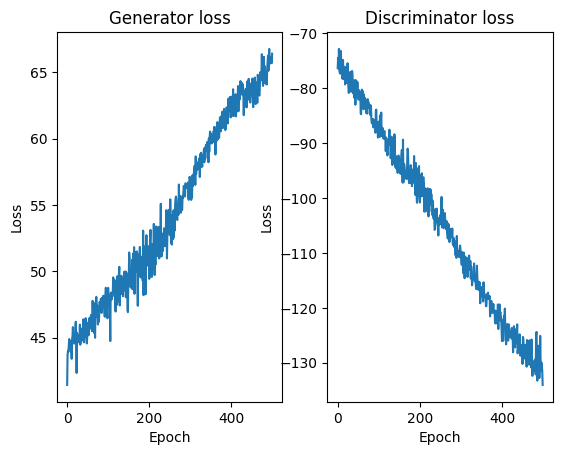

In [25]:
from matplotlib import pyplot as plt
print(history.history.keys()) #dict_keys(['d0_loss', 'g0_loss'])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['g_loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.set_title('Generator loss')
ax2.plot(history.history['d_loss'])
ax2.set_title('Discriminator loss')
# plt.xscale('log')
ax2.set(xlabel='Epoch', ylabel='Loss')
#plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()


In [37]:
### Recontruct from voxels to mesh

# !pip install trimesh
# !pip install PyMCubes

import trimesh
import numpy as np
from mcubes import marching_cubes
import pandas as pd

# normalise within unit sphere:
def normalize_unit_sphere(vertices):
  mean_vertices = np.mean(vertices, axis=0)
  vertices -= mean_vertices # mean subtracted from all vertices
  max_distance = np.max(np.sqrt(np.sum(abs(vertices)**2,axis=-1))) #max distance from origin
  vertices /= max_distance #all vertices are divided by the maximum of such distances
  #All distances are scaled to the range -1.0 and 1.0.
  return vertices

# Convert the tensor data into a trimesh volume
loaded_voxels = np.loadtxt("generated_shape_0_300.txt")
load_original_voxels = loaded_voxels.reshape(
    loaded_voxels.shape[0], loaded_voxels.shape[1] // original_voxels_0.shape[2], original_voxels_0.shape[2])
vertices, faces = marching_cubes(load_original_voxels, 0.5)
#print(vertices)
#normalise vertices
vertices = normalize_unit_sphere(vertices)
volume_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
print(volume_mesh)
volume_mesh.show()


<trimesh.Trimesh(vertices.shape=(580, 3), faces.shape=(1057, 3))>
